### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
# batch size
bs = 30

In [8]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/ru-100-unk/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-100-unk/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-100-unk/models'),
 PosixPath('data/wiki/ru-100-unk/tmp_lm'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens.temp')]

In [11]:
# provide train and valid path
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [12]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [13]:
itos = data_lm.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n \n ', 'на', ')', '(', '\n ', '—', '«', '»']


In [14]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(189786, 447)

In [15]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « xxunk , xxunk , xxunk » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вид

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj xxunk , xxmaj фриц = \n xxmaj xxunk , xxmaj фриц \n \n xxmaj фриц xxmaj xxunk ( ; 18 июля 1910 , , xxmaj германская империя — дата смерти неизвестна ) — xxunk xxup сс , руководитель xxunk xxunk , xxunk массовые убийства на xxmaj украине , сотрудник xxup xxunk . \n \n xxmaj биография . \n xxmaj его братом"
1,"xxmaj после xxunk обратного свода , укладки пути , xxunk и подключения коммуникаций новый xxmaj xxunk тоннель был введён в эксплуатацию . xxmaj сдача тоннеля в эксплуатацию состоялась 25 декабря 2012 года . \n \n xxmaj считается , что строительство нового тоннеля позволит резко увеличить объём железнодорожных перевозок на xxmaj восточном xxunk направлением на xxmaj xxunk и xxmaj советскую xxmaj гавань — с 12 млн т в 2009 году"
2,"скульпторы , такие , как xxmaj xxunk , xxmaj xxunk , xxmaj xxunk и многие другие , увидев xxmaj xxunk , просили его xxunk им . xxmaj георг был также любимой моделью известного эстонского скульптора xxmaj xxunk xxmaj xxunk , выпускника xxmaj петербургской xxmaj академии художеств . xxmaj одна из их совместных работ — « xxmaj чемпион » — была удостоена первой премии на всемирной выставке 1904 года в xxmaj"
3,"xxmaj грузии xxmaj михаил xxmaj саакашвили в своём xxunk заявил об « освобождении » xxunk структурами xxmaj грузии xxmaj xxunk и xxmaj xxunk районов , сел xxmaj xxunk , xxmaj xxunk и xxmaj xxunk , а также большей части xxmaj xxunk . xxmaj он обвинил xxmaj россию в бомбардировке территории xxmaj грузии , назвав это « классической международной xxunk » . \n \n xxmaj утром 9 августа помощник главкома"
4,"1803 году местное население составляло от 5 до 10 тысяч человек . xxmaj из - за xxunk европейцами инфекционных заболеваний , к которым у аборигенов не было иммунитета , войны и преследований коренное население острова сократилось к 1833 году до 300 человек . xxmaj почти все аборигены были переселены xxmaj джорджем xxmaj августом xxmaj xxunk на остров xxmaj xxunk . \n \n xxmaj женщина по имени xxmaj xxunk ("


In [17]:
# save databunch
data_lm.save('tmp_lm')

In [10]:
# load databunch
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

#### Create Learner and train Language Model

In [12]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [13]:
learner.load('ru-100-unk-best')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (189786 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/wiki/ru-100-unk
x: LMTextList (189786 items)
[Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнооб

In [14]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [16]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7fb0d165cf28>>]

In [17]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [18]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [19]:
# unfreeze all layers
learner.unfreeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


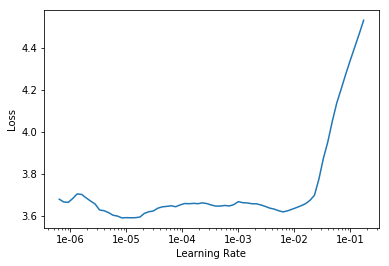

In [26]:
learner.recorder.plot(skip_end=15)

In [22]:
# define non-default momentums
moms=(0.8,0.7)

In [23]:
learner.fit_one_cycle(4, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.650695,3.406265,0.428821
2,3.780002,3.396528,0.429244
3,3.829076,3.364912,0.435912
4,3.584365,3.340251,0.439377


In [24]:
# save model
learner.save('ru-100-unk-best')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Fine tune on ruSentiment

http://text-machine.cs.uml.edu/projects/rusentiment/

In [7]:
# path for ruSentiment data
rusent_data_path = Path('data/ruSentiment/')

In [8]:
bs = 48

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/train'),
 PosixPath('data/ruSentiment/valid'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [10]:
# create LM DataBunch from ruSentEval unsupervised corpus of tweets http://study.mokoron.com/
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'unsup_sample.csv', text_cols=0,
                                    valid_pct=0.1, bs=bs)

In [11]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '/', ':', ',', 'http', 't.co', '.', 'в', '#', 'rt', 'и', 'не', '-']
data/ruSentiment


In [12]:
(data1_lm.path).ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/train'),
 PosixPath('data/ruSentiment/valid'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [13]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(1799487, 199944)

In [10]:
data1_lm.show_batch()

idx,text
0,"xxbos xxmaj страны - члены xxup вто договорились о реформе организации xxbos xxmaj всегда говорю , что нормально все будет и никто не умрет xxbos чай , таблетки , теплые носки и шарф \n опять простуда ( ( xxbos сын зашел к матери а у матери упало полотенце видео http : / / t.co / xxunk xxbos xxmaj скажите вслух не xxunk - xxmaj миша , xxmaj xxunk , медведь"
1,"xxmaj марьино для моряков xxbos xxmaj снукер - xxmaj чемпионат xxmaj британии - xxmaj трое в пути . xxmaj чемпионат xxmaj британии & … xxbos xxmaj хахаха http : / / t.co / xxunk xxbos xxmaj не совсем понимаю зачем вы смотрите этот xxunk престарелых пидарасов , ребята . # xxunk xxbos отличие 8 часов . xxmaj так что в 18.00 по белорусскому времени должен быть"
2,"с ним , \n xxmaj чтоб каждый увидел и понял суть : \n xxmaj успей любить . xxmaj годы не вернуть , время не вернуть ♥ xxbos xxunk no \n xxunk лицо группы xdd xxbos xxmaj можно ли завоевать свободу при помощи насилия ? xxbos xxmaj глава xxmaj московской xxmaj хельсинкской группы рассказала lifenews о своих впечатлениях от неожиданной встречи с xxunk xxmaj администрации ... xxbos xxup rt @no_4_u :"
3,- http : / / t.co / xxunk xxbos xxup rt @olka_luchik : xxunk вкуснятина * о * спасибо:3 xxbos этот тупой апрель все лезет к нам обоим в душу xxbos http : / / t.co / xxunk как приготовить зеленый кофе с имбирем для похудения в домашних условиях xxbos xxup rt xxunk : # хочупровестиновогоднююночьвместес xxunk http : / / t.co / xxunk xxbos xxup rt xxunk : xxmaj
4,"твит # mtvstars xxmaj one xxmaj direction http : / / t.co / xxunk m xxbos xxmaj снукер - xxmaj чемпионат xxmaj британии - xxmaj кто же первый на турнире и в рейтинге ? xxbos xxmaj это был xxmaj xxunk xxmaj xxunk , рыцарь кисти , аналитик , xxunk , философ , гражданин и член . xxmaj элиты , в смысле . xxbos грубо . \n"


In [16]:
data1_lm.train_ds[0]

(Text xxbos xxup rt xxunk : в xxunk дверь , xxunk на пороге , xxunk xxunk походкой xxunk и xxunk .,
 Category 0)

In [17]:
# save data bunch 
data1_lm.save('tmp_lm')

In [9]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm', bs=bs)

#### Create Learner and Finetune model from pretrained fnames

In [10]:
# pretrained model and vocab from first step of training LM
pretrained_fnames = ['ru-100-unk-best', 'itos']

In [11]:
# create learner and provide pretrained files to finetune wiki-LM with ruSentiment data
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=1.0)

Unknown tokens 32987, first 100: ['t.co', 'rt', '"', 'mtvstars', 'seconds', 'direction', 'гдз', ':)', '\xa0', ':d', 'gameinsight', '\n\n', ':3', 'решебник', 'androidgames', 'шлюхи', 'имбирем', 'блять', 'блин', 'бля', 'justin', 'bieber', 'ахах', 'ненавижу', 'пойду', 'ахаха', '©', '@youtube', 'євромайдан', 'массаж', 'пиздец', 'твит', '️', 'хд', 'ipadgames', 'сижу', 'похудения', 'сука', 'твиттер', ':(', 'ладно', 'смотрю', 'евромайдан', 'ахахах', 'андроид', '\n\n ', 'жду', ';)', 'нахуй', 'лол', 'урока', 'торрент', 'конспект', '\xa0 ', '❤', 'обожаю', 'прям', 'хочупровестиновогоднююночьвместес', 'бесит', 'болит', ':-)', 'майдан', 'щас', 'дp', '4о', 'o5', 'о5', '^^', 'ретвит', 'ищу', '4o', 'бл', '♥', 'фгос', '11.12.13', 'проверь', '@koffboy', 'боюсь', 'ох', 'скучаю', 'жуйк', 'майдане', 'грядки', '@5umm', 'чувак', 'ответами', 'радует', ':*', 'любишь', 'тви', 'делаю', 'янукович', 'интим', 'ахахаха', 'реферат', '<3', 'говно', 'лень', 'iphonegames', 'хуй']


In [12]:
learner.callback_fns += [partial(CSVLogger, filename=f"{learner.model_dir}/lm-history"),
                         partial(SaveModelCallback, every='epoch', name='lm')]

In [13]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.csv_logger.CSVLogger'>, filename='models/lm-history'),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [14]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [16]:
learner.true_wd

True

In [17]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7fd403d98f28>>]

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


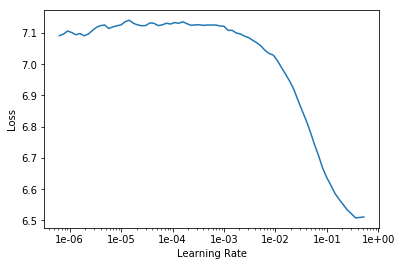

In [19]:
learner.recorder.plot(skip_end=15)

In [20]:
moms = (0.8, 0.7)

In [ ]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy


In [38]:
learner.save('fit_head')

In [39]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (223291 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (223291 items)
[Text xxbos xxmaj из - за любви , я хотела покончить жизнь самоубийством . xxmaj но меня xxunk семья , а душа заставляет запивать горе алкоголем ( ( (, Text xxbos xxup rt xxunk : xxmaj как всегда предновогодняя депрессия ... когда не знаешь ответы на вопросы зачем , xxmaj почему , когда и себе выносишь мозг ! ( ( (, Text xxbos xxmaj по - моему все женщины ходят в пуховике этой осенью ) думаю тоже себе прикупить пуховик, Text xxbos xxup rt @xmelniczkaya : только что звонила xxmaj таня , со xxunk , xxunk .. дружелюбно однако ), Text xxbos @bastaakanoggano xxmaj спасибо за трек " xxmaj xxunk " ! ! xxmaj аж отпустило окончательно ) ) )]...
Path: data/ruSentiment;

Valid: LabelList
y: LMLabel (24811 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: L

In [46]:
learner.unfreeze()

In [47]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


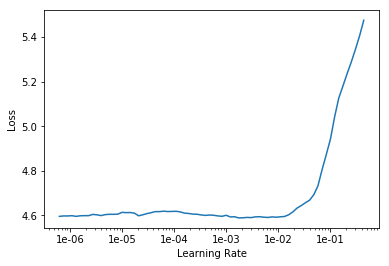

In [48]:
learner.recorder.plot(skip_end=15)

In [49]:
learner.fit_one_cycle(10, 3e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.394020,4.436266,0.289822
2,4.297424,4.324753,0.302021
3,4.209537,4.242235,0.309714
4,4.096015,4.179562,0.318155
5,3.967975,4.143805,0.323483
6,3.821845,4.130220,0.327981
7,3.674572,4.138653,0.330129
8,3.531590,4.153129,0.332132
9,3.386323,4.182457,0.331589
10,3.320972,4.197162,0.330917


In [53]:
# save fine_tuned model
learner.save('fine_tuned')

In [54]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [51]:
# check text generation with LM
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [52]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я жалюзи @alburov скуучно @espro войти настроилась почистила 2010 приходить профессии
сегодня утром я стоящая разного т___т вслух имеешь печь долгожданные ступоре правдивая @olegkong


### Classifier

In [10]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [11]:
rand = pd.read_csv(rusent_data_path/'rusentiment_random_posts.csv')
presel = pd.read_csv(rusent_data_path/'rusentiment_preselected_posts.csv')

In [16]:
# create classification databunch, please note usage of LM vocab
data_clas = TextClasDataBunch.from_df(path=rusent_data_path,
                                      train_df=pd.concat([rand, presel], ignore_index=True),
                                      valid_df=pd.read_csv(rusent_data_path/'rusentiment_test.csv'),
                                      vocab=data1_lm.vocab, text_cols='text', label_cols='label', bs=bs)

In [17]:
data_clas.show_batch()

text,target
"xxbos - xxmaj отдать тебе любовь ? \n - xxmaj отдай . \n - xxmaj она в грязи . \n - xxmaj отдай в грязи . \n - я погадать хочу . \n - xxmaj гадай \n - xxmaj еще спросить хочу . \n - xxmaj спроси . \n - xxmaj допустим , xxunk . \n - xxmaj xxunk . \n - xxmaj допустим , позову . \n - xxmaj",neutral
"xxbos xxunk xxmaj харьков ! ! xxunk \n\n xxunk xxunk xxup очередное xxup пополнение xxunk xxunk xxunk \n xxup бездомных xxup котят ! xxunk xxunk xxunk \n\n у нас прибавилось забот . очередные котята были xxunk с улицы с xxunk xxunk . у многих xxunk и xxunk глазки , один котенок с xxunk кожи , точнее скажет xxunk . \n xxmaj замечательная женщина xxmaj люба взяла на себя снова xxunk",neutral
"xxbos у меня есть друг и он мечтал о xxunk \n xxmaj но xxunk книгу xxunk с собой везде \n xxmaj ребята на xxunk говорили - не нормально \n xxmaj что xxunk и кастрюля занимают пол спальни \n и пока мы бегали к красивым девчонкам \n xxmaj он варил кашу он стоял в сторонке \n\n и он кричал "" я все равно буду коп xxrep 4 а ть "" \n",skip
"xxbos xxmaj ура ! xxmaj весна пришла весне дорогу ) ! xxmaj день всех милых и не очень дам xxunk ближайшие два дня мы будем наблюдать за фотографиями цветов , за моими любимыми фотографиями цветов ) ! ! xxmaj за этими xxunk видами тюльпанов ! ! ) ) а мои вот цветочки и подарочки сидят дома и отказываются зафоткаться , так скажем не xxunk , или я такая не девчонка",positive
"xxbos xxmaj то что болезнь это давно известно и мною и коллегами по учёбе в 90-е ещё кратко и понятно xxunk — \n\n "" xxmaj любовь есть психическое расстройство , xxunk xxunk электро - xxunk реакций "" . \n\n xxmaj однако есть и другая сторона медали . \n\n xxmaj это и будет ответ на вопрос почему бабы так упороты на любви . \n xxmaj всё дело в изменении xxunk внутри",neutral


In [18]:
# number of classes
data_clas.train_ds.c

5

In [19]:
data_clas.train_ds.classes

['negative', 'neutral', 'positive', 'skip', 'speech']

In [20]:
data_clas

TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: data/ruSentiment
x: TextList (28218 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: data/ruSentiment
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к ново

In [21]:
len(data_clas.vocab.itos)

60003

In [22]:
data_clas.batch_size

24

In [23]:
# save for future use
data_clas.save('tmp_clas')

In [10]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_clas', bs=bs)

#### Training

In [24]:
# create learner and train
# train classifier as in fastai imdb example
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [25]:
# load fine tuned encoder
learner.load_encoder('fine_tuned_enc')

In [26]:
learner.freeze()

In [27]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


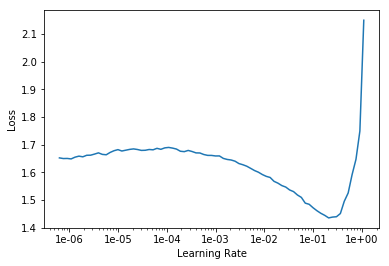

In [28]:
learner.recorder.plot()

In [29]:
moms=(0.8,0.7)

In [30]:
learner.fit_one_cycle(2, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.127550,0.919115,0.649815
2,1.068637,0.884026,0.653185


In [31]:
learner.save('first')

In [14]:
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [32]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.017036,0.808343,0.686889
2,0.930588,0.849929,0.686552


In [33]:
learner.save('second')

In [36]:
learner.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [34]:
learner.unfreeze()
learner.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.879912,0.799327,0.689248
2,0.866167,0.969828,0.690597
3,0.830565,0.784415,0.695315
4,0.824021,0.797779,0.685541
5,0.804852,0.779965,0.700034
6,0.795080,0.787774,0.698011


In [35]:
learner.save('best-classifier')

In [36]:
# sanity check for accuracy, precision, recall and f1-score
preds, targets = learner.get_preds()

In [37]:
targets.unique()

tensor([4, 0, 2, 3, 1])

In [38]:
pred_classes = torch.argmax(preds, dim=1)

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(targets, pred_classes, target_names=data_clas.train_ds.classes))

              precision    recall  f1-score   support

    negative       0.57      0.48      0.52       258
     neutral       0.77      0.76      0.76      1420
    positive       0.54      0.62      0.58       536
        skip       0.50      0.45      0.47       346
      speech       0.90      0.95      0.92       407

   micro avg       0.70      0.70      0.70      2967
   macro avg       0.66      0.65      0.65      2967
weighted avg       0.70      0.70      0.70      2967



In [44]:
# check prediction for one example
learner.predict('сомнительная перспектива')

(Category neutral, tensor(1), tensor([0.1436, 0.6490, 0.0511, 0.1547, 0.0016]))